# Space Debris Dataset - Model Training & Evaluation

**Dataset**: `space_decay_cleaned.csv` (from EDA notebook)

**Objective**: Build and evaluate machine learning models to predict space object types.

---

## This Notebook Covers:
1. Data Loading & Feature Selection
2. Feature Engineering
3. Data Preprocessing for Modeling
4. Model Building (Multiple Algorithms)
5. Model Evaluation & Comparison
6. Advanced Metrics & Diagnostics
7. Model Saving & Deployment


## Phase 1: Data Loading & Preparation


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_curve, auc, roc_auc_score)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [2]:
# Load cleaned data from EDA notebook
df = pd.read_csv('data/space_decay_cleaned.csv')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")


Dataset loaded successfully!
Shape: 14372 rows × 39 columns


In [3]:
# Preview data
df.head()


,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,...,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T06:46:11,18 SPCS,ARIANE 42P+ DEB,1992-072J,EARTH,TEME,UTC,SGP4,...,DEBRIS,MEDIUM,FR,1992.0,FRGUI,3195178,188614016,0 ARIANE 42P+ DEB,1 26741U 92072J 21304.94919376 .00000883 0...,2 26741 7.7156 90.2410 6528926 243.1216 38...
1,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T04:58:37,18 SPCS,SL-8 DEB,1979-028C,EARTH,TEME,UTC,SGP4,...,DEBRIS,SMALL,CIS,1979.0,PKMTR,3194950,188593285,0 SL-8 DEB,1 26743U 79028C 21304.68908982 .00000079 0...,2 26743 82.9193 299.1120 0030720 158.9093 201...
2,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T06:26:11,18 SPCS,GSAT 1,2001-015A,EARTH,TEME,UTC,SGP4,...,PAYLOAD,LARGE,IND,2001.0,SRI,3195026,188609573,0 GSAT 1,1 26745U 01015A 21305.22411368 -.00000165 0...,2 26745 12.1717 16.5368 0237386 250.1248 146...
3,2,GENERATED VIA SPACE-TRACK.ORG API,2021-10-31T18:07:15,18 SPCS,CZ-4 DEB,1999-057MB,EARTH,TEME,UTC,SGP4,...,DEBRIS,SMALL,PRC,1999.0,TSC,3194431,188556894,0 CZ-4 DEB,1 26754U 99057MB 21304.46625230 .00002265 0...,2 26754 98.4781 8.7205 0060618 37.3771 323...
4,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T04:58:37,18 SPCS,CZ-4 DEB,1999-057MC,EARTH,TEME,UTC,SGP4,...,DEBRIS,SMALL,PRC,1999.0,TSC,3194950,188592541,0 CZ-4 DEB,1 26755U 99057MC 21304.74081807 .00002610 0...,2 26755 98.4232 122.0724 0062255 345.1605 27...


---
## Phase 2: Feature Engineering

Create new features that might improve model performance.


In [4]:
# Define target variable
target_column = 'OBJECT_TYPE'

# Select relevant features for modeling
feature_columns = [
    'MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE',
    'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'BSTAR', 'MEAN_MOTION_DOT',
    'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS', 'REV_AT_EPOCH',
    'COUNTRY_CODE', 'CLASSIFICATION_TYPE'
]

# Filter only existing columns
feature_columns = [col for col in feature_columns if col in df.columns]
print(f"Selected {len(feature_columns)} features for modeling:")


Selected 15 features for modeling:


In [5]:
# Create engineered features
df_engineered = df.copy()

# Feature 1: Orbit eccentricity category
if 'ECCENTRICITY' in df_engineered.columns:
    df_engineered['orbit_eccentricity_category'] = pd.cut(
        df_engineered['ECCENTRICITY'],
        bins=[0, 0.1, 0.4, 1.0],
        labels=['Circular', 'Elliptical', 'Highly_Elliptical']
    )
    df_engineered['orbit_eccentricity_category'] = df_engineered['orbit_eccentricity_category'].cat.codes

# Feature 2: Altitude category (LEO, MEO, GEO, etc.)
if 'SEMIMAJOR_AXIS' in df_engineered.columns:
    df_engineered['altitude_category'] = pd.cut(
        df_engineered['SEMIMAJOR_AXIS'],
        bins=[0, 8000, 20000, 42000, np.inf],
        labels=['LEO', 'MEO', 'GEO', 'Beyond_GEO']
    )
    df_engineered['altitude_category'] = df_engineered['altitude_category'].cat.codes

print(f"Feature engineering completed!")
print(f"New shape: {df_engineered.shape}")


Feature engineering completed!
New shape: (14372, 41)


---
## Phase 3: Data Preprocessing for Modeling

### Key Steps:
1. Feature selection
2. Encoding categorical variables
3. Train/validation/test split
4. Feature scaling


In [6]:
# Create modeling dataset
if target_column in df_engineered.columns:
    df_model = df_engineered[feature_columns + [target_column]].copy()
    df_model = df_model.dropna(subset=[target_column])
    print(f"Modeling dataset shape: {df_model.shape}")
    
    # Add engineered features
    if 'orbit_eccentricity_category' in df_engineered.columns:
        df_model['orbit_eccentricity_category'] = df_engineered['orbit_eccentricity_category']
    if 'altitude_category' in df_engineered.columns:
        df_model['altitude_category'] = df_engineered['altitude_category']
    
    print(f"Final shape with engineered features: {df_model.shape}")


Modeling dataset shape: (14372, 16)
Final shape with engineered features: (14372, 18)


In [7]:
# Encode categorical features
label_encoders = {}
for col in df_model.select_dtypes(include=['object']).columns:
    if col != target_column:
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique values")

# Encode target variable
if target_column and df_model[target_column].dtype == 'object':
    le_target = LabelEncoder()
    df_model[f'{target_column}_encoded'] = le_target.fit_transform(df_model[target_column])
    label_encoders[target_column] = le_target
    print(f"\nTarget classes: {le_target.classes_}")


Encoded COUNTRY_CODE: 99 unique values


Encoded CLASSIFICATION_TYPE: 1 unique values

Target classes: ['DEBRIS' 'PAYLOAD' 'ROCKET BODY' 'TBA']


In [8]:
# Prepare features and target
if f'{target_column}_encoded' in df_model.columns:
    y = df_model[f'{target_column}_encoded']
    X = df_model.drop(columns=[target_column, f'{target_column}_encoded'])
else:
    y = df_model[target_column]
    X = df_model.drop(columns=[target_column])

# Keep only numeric columns
X = X.select_dtypes(include=['int64', 'float64'])

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target classes: {y.nunique()}")


Features shape: (14372, 15)
Target shape: (14372,)
Target classes: 4


In [9]:
# Split data: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)  # 0.176 of 85% ≈ 15% of total

print("Data split completed:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")


Data split completed:


Training set: 10065 samples (70.0%)
Validation set: 2151 samples (15.0%)
Test set: 2156 samples (15.0%)


In [10]:
# Feature scaling
scaler = StandardScaler()

# Fit on training data only (avoid data leakage!)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✓ Feature scaling completed!")


✓ Feature scaling completed!


---
## Phase 4: Class Imbalance Analysis

Before building models, check for class imbalance which can bias results.


In [11]:
# Check class imbalance
class_counts = y.value_counts().sort_index()
class_percentages = (class_counts / len(y) * 100).round(2)

print("=" * 60)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 60)

imbalance_df = pd.DataFrame({
    'Class': class_counts.index,
    'Count': class_counts.values,
    'Percentage': class_percentages.values
})
print(imbalance_df.to_string(index=False))

# Calculate imbalance ratio
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count

print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("⚠️  WARNING: Significant class imbalance detected!")
    print("   Models will use class_weight='balanced' parameter")
else:
    print("✓ Classes are relatively balanced")


CLASS IMBALANCE ANALYSIS
 Class  Count  Percentage
     0   8431       58.66
     1   4950       34.44
     2    744        5.18
     3    247        1.72

Imbalance Ratio: 34.13:1
⚠️  WARNING: Significant class imbalance detected!
   Models will use class_weight='balanced' parameter


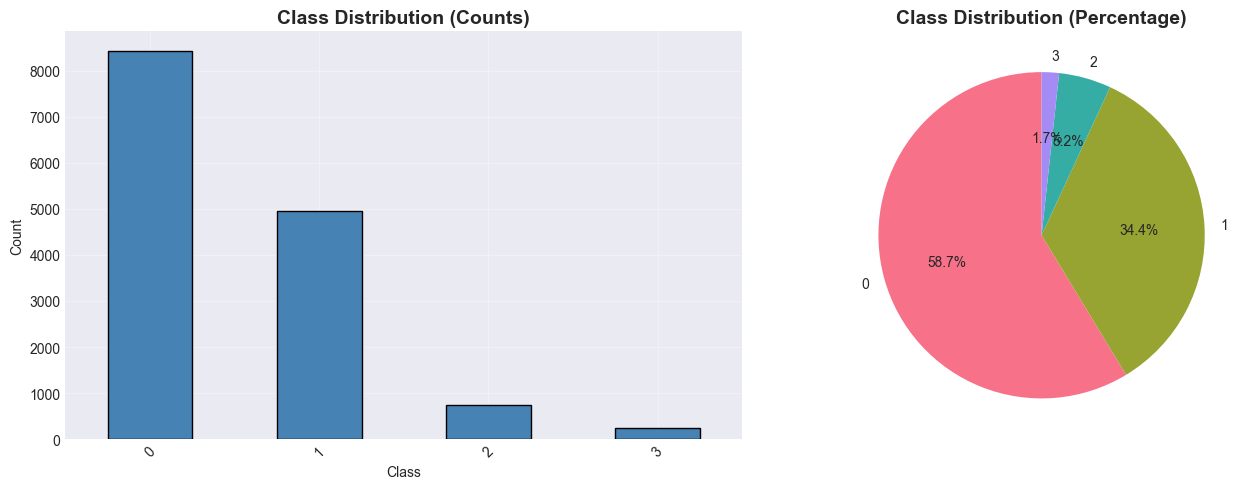

In [12]:
# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_title('Class Distribution (Counts)', fontsize=14, weight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette('husl', len(class_counts)))
ax2.set_title('Class Distribution (Percentage)', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()


---
## Phase 5: Model Building

### Models to Train:
1. **Logistic Regression** - Simple baseline
2. **Random Forest** - Ensemble method
3. **XGBoost** (optional) - Gradient boosting


### Model 1: Logistic Regression


In [13]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_val_scaled)

# Evaluation
print("=" * 60)
print("LOGISTIC REGRESSION RESULTS")
print("=" * 60)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lr))


LOGISTIC REGRESSION RESULTS
Validation Accuracy: 0.6490

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.73      0.79      1262
           1       0.86      0.52      0.65       741
           2       0.25      0.65      0.36       111
           3       0.06      0.54      0.10        37

    accuracy                           0.65      2151
   macro avg       0.51      0.61      0.48      2151
weighted avg       0.82      0.65      0.71      2151



### Model 2: Random Forest


In [14]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_val_scaled)

# Evaluation
print("=" * 60)
print("RANDOM FOREST RESULTS")
print("=" * 60)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))


RANDOM FOREST RESULTS
Validation Accuracy: 0.9200

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1262
           1       0.95      0.92      0.94       741
           2       0.54      0.75      0.63       111
           3       0.55      0.59      0.57        37

    accuracy                           0.92      2151
   macro avg       0.75      0.80      0.77      2151
weighted avg       0.93      0.92      0.92      2151



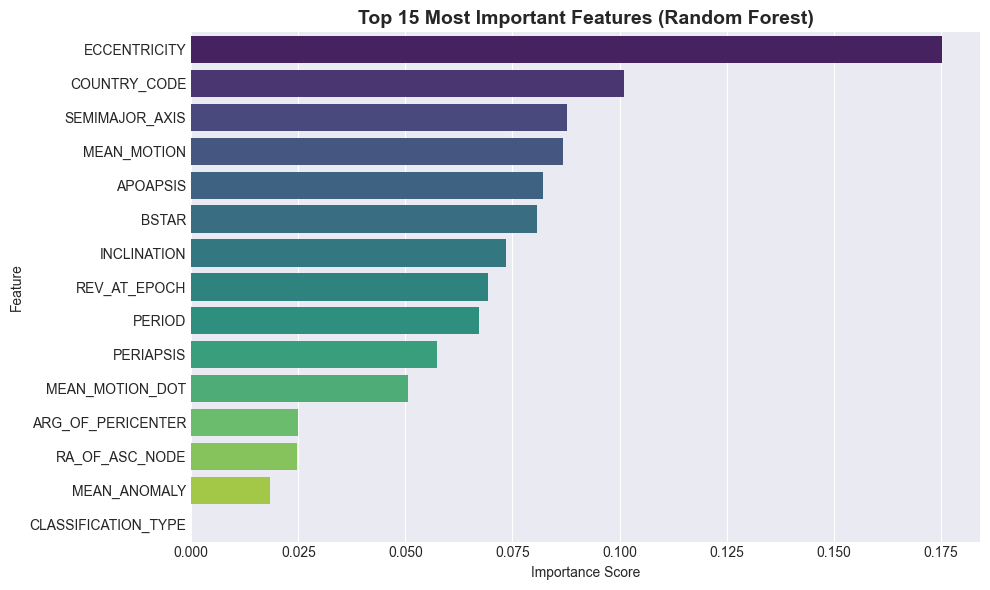

In [15]:
# Feature Importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, weight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Model 3: XGBoost (Optional)


In [16]:
# Try importing XGBoost
try:
    import xgboost as xgb
    xgboost_available = True
    
    # Calculate class weights
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights = compute_sample_weight('balanced', y_train)
    
    # Train XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
    
    # Predictions
    y_pred_xgb = xgb_model.predict(X_val_scaled)
    
    # Evaluation
    print("=" * 60)
    print("XGBOOST RESULTS")
    print("=" * 60)
    print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_xgb):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_xgb))
    
except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")
    xgboost_available = False


XGBOOST RESULTS
Validation Accuracy: 0.9363

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1262
           1       0.95      0.94      0.94       741
           2       0.62      0.76      0.68       111
           3       0.65      0.76      0.70        37

    accuracy                           0.94      2151
   macro avg       0.80      0.85      0.82      2151
weighted avg       0.94      0.94      0.94      2151



---
## Phase 6: Model Comparison

Compare all trained models.



MODEL COMPARISON
              Model  Accuracy
Logistic Regression  0.649000
      Random Forest  0.920037
            XGBoost  0.936309


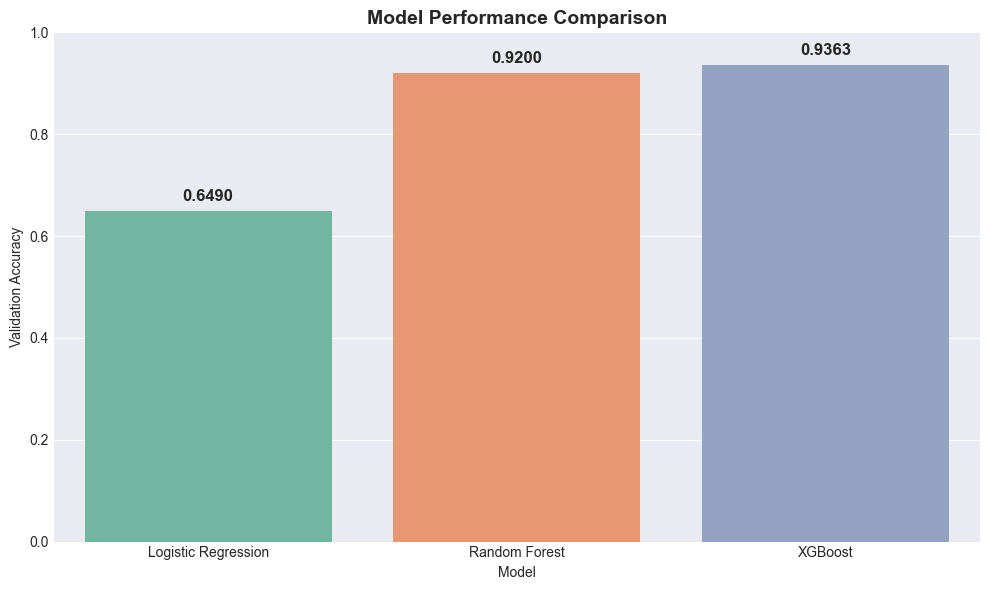

In [17]:
# Compare models
results_list = [
    {'Model': 'Logistic Regression', 'Accuracy': accuracy_score(y_val, y_pred_lr)},
    {'Model': 'Random Forest', 'Accuracy': accuracy_score(y_val, y_pred_rf)}
]

if xgboost_available and 'y_pred_xgb' in locals():
    results_list.append({'Model': 'XGBoost', 'Accuracy': accuracy_score(y_val, y_pred_xgb)})

results = pd.DataFrame(results_list)

print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(results.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Model', y='Accuracy', palette='Set2')
plt.title('Model Performance Comparison', fontsize=14, weight='bold')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(results['Accuracy']):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


---
## Phase 7: Advanced Model Evaluation

### Cross-Validation for Robust Performance Estimates


In [18]:
# 5-Fold Cross-Validation
print("=" * 60)
print("CROSS-VALIDATION ANALYSIS (5-Fold)")
print("=" * 60)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_cv = np.vstack([X_train_scaled, X_val_scaled])
y_cv = pd.concat([y_train, y_val])

cv_results = {}

# Logistic Regression CV
lr_cv = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
scores = cross_val_score(lr_cv, X_cv, y_cv, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
cv_results['Logistic Regression'] = {'Mean': scores.mean(), 'Std': scores.std(), 'Scores': scores}
print(f"\nLogistic Regression:")
print(f"  Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Random Forest CV
rf_cv = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, 
                               class_weight='balanced', n_jobs=-1)
scores = cross_val_score(rf_cv, X_cv, y_cv, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
cv_results['Random Forest'] = {'Mean': scores.mean(), 'Std': scores.std(), 'Scores': scores}
print(f"\nRandom Forest:")
print(f"  Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")


CROSS-VALIDATION ANALYSIS (5-Fold)



Logistic Regression:
  Accuracy: 0.6543 (+/- 0.0123)



Random Forest:
  Accuracy: 0.9273 (+/- 0.0008)


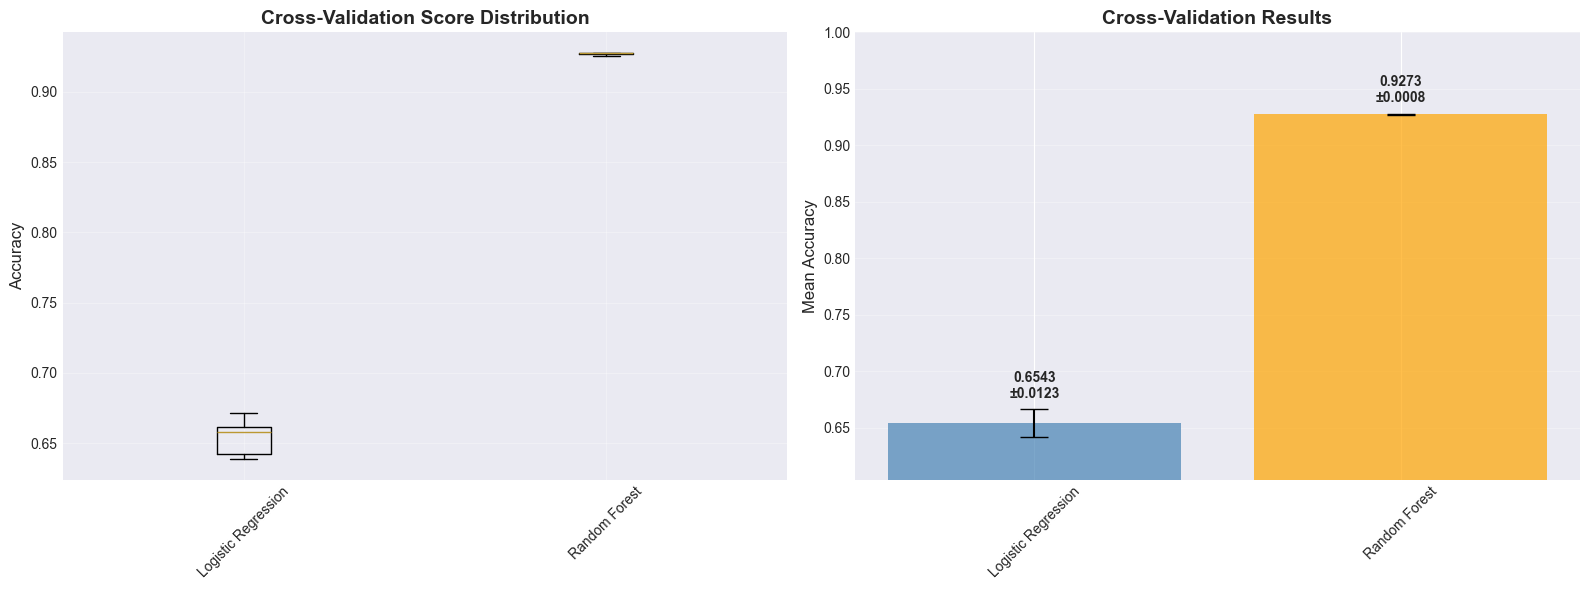

In [19]:
# Visualize CV results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
cv_data = [cv_results[model]['Scores'] for model in cv_results.keys()]
ax1.boxplot(cv_data, labels=cv_results.keys())
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Cross-Validation Score Distribution', fontsize=14, weight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Bar plot with error bars
models = list(cv_results.keys())
means = [cv_results[m]['Mean'] for m in models]
stds = [cv_results[m]['Std'] for m in models]

ax2.bar(models, means, yerr=stds, capsize=10, alpha=0.7, color=['steelblue', 'orange'])
ax2.set_ylabel('Mean Accuracy', fontsize=12)
ax2.set_title('Cross-Validation Results', fontsize=14, weight='bold')
ax2.set_ylim([min(means) - 0.05, 1.0])
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

for i, (m, s) in enumerate(zip(means, stds)):
    ax2.text(i, m + s + 0.01, f'{m:.4f}\n±{s:.4f}', ha='center', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()


### Confusion Matrix Analysis


In [20]:
# Select best model
best_model_idx = results['Accuracy'].idxmax()
best_model_name = results.loc[best_model_idx, 'Model']

if best_model_name == 'Logistic Regression':
    best_model = lr_model
    y_pred_best = y_pred_lr
elif best_model_name == 'Random Forest':
    best_model = rf_model
    y_pred_best = y_pred_rf
else:
    best_model = xgb_model
    y_pred_best = y_pred_xgb

print(f"\n✓ Best Model: {best_model_name}")



✓ Best Model: XGBoost


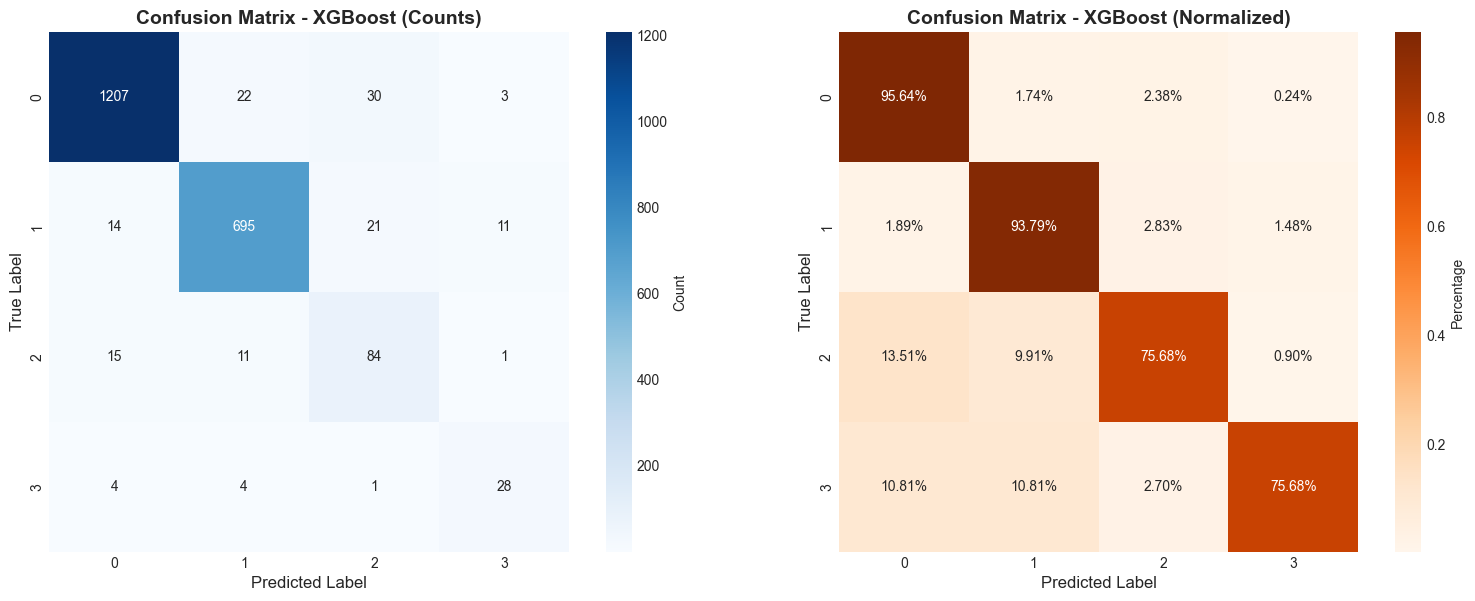

In [21]:
# Enhanced confusion matrix
cm = confusion_matrix(y_val, y_pred_best)
cm_normalized = confusion_matrix(y_val, y_pred_best, normalize='true')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, ax=ax1,
            cbar_kws={'label': 'Count'})
ax1.set_title(f'Confusion Matrix - {best_model_name} (Counts)', fontsize=14, weight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges', square=True, ax=ax2,
            cbar_kws={'label': 'Percentage'})
ax2.set_title(f'Confusion Matrix - {best_model_name} (Normalized)', fontsize=14, weight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()


### Learning Curves - Diagnose Overfitting/Underfitting


In [22]:
# Calculate learning curves
print("Computing learning curves...")

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_cv, y_cv,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

print(f"✓ Learning curves computed for {best_model_name}")


Computing learning curves...


✓ Learning curves computed for XGBoost


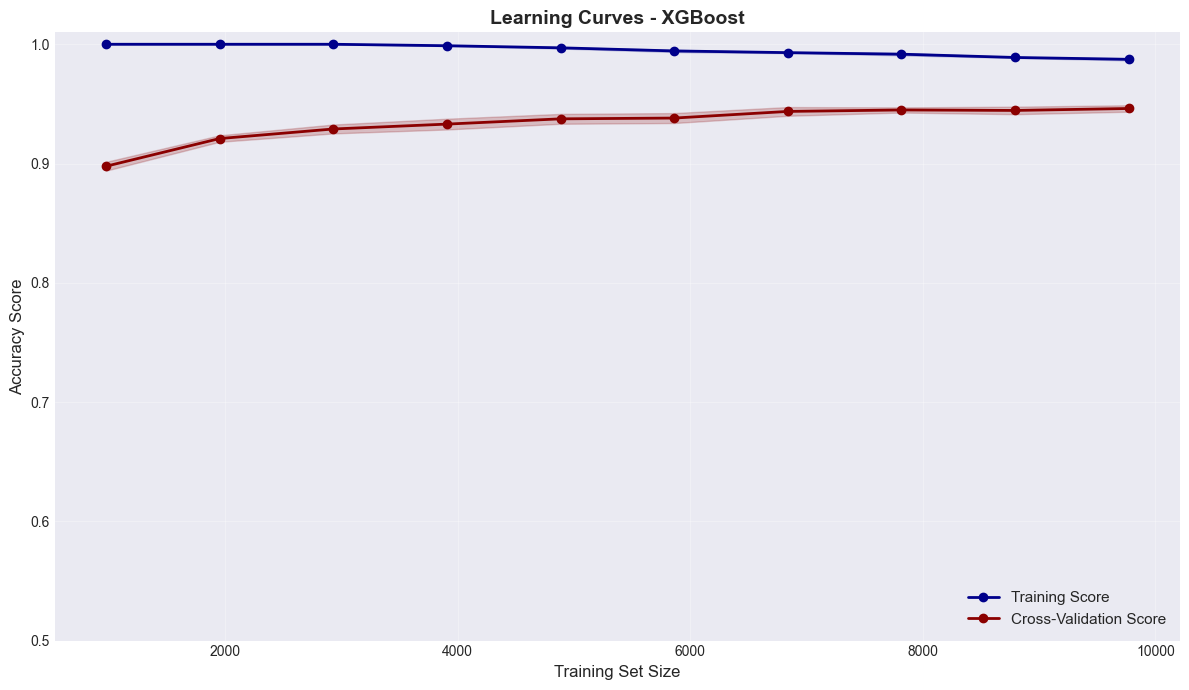


📊 Learning Curve Diagnosis:
   Final Training Score: 0.9874
   Final Validation Score: 0.9461
   Gap: 0.0412

✓ Model appears well-balanced!


In [23]:
# Plot learning curves
plt.figure(figsize=(12, 7))

plt.plot(train_sizes, train_mean, 'o-', color='darkblue', linewidth=2, label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 alpha=0.2, color='darkblue')

plt.plot(train_sizes, val_mean, 'o-', color='darkred', linewidth=2, label='Cross-Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                 alpha=0.2, color='darkred')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title(f'Learning Curves - {best_model_name}', fontsize=14, weight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.01])
plt.tight_layout()
plt.show()

# Diagnosis
final_gap = train_mean[-1] - val_mean[-1]
print(f"\n📊 Learning Curve Diagnosis:")
print(f"   Final Training Score: {train_mean[-1]:.4f}")
print(f"   Final Validation Score: {val_mean[-1]:.4f}")
print(f"   Gap: {final_gap:.4f}")

if final_gap > 0.1:
    print("\n⚠️  HIGH VARIANCE (Overfitting)")
elif val_mean[-1] < 0.7:
    print("\n⚠️  HIGH BIAS (Underfitting)")
else:
    print("\n✓ Model appears well-balanced!")


---
## Phase 8: Final Test Set Evaluation

Evaluate best model on unseen test data.


In [24]:
# Test set evaluation
y_test_pred = best_model.predict(X_test_scaled)

print("\n" + "=" * 60)
print(f"FINAL TEST SET EVALUATION - {best_model_name}")
print("=" * 60)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred))



FINAL TEST SET EVALUATION - XGBoost
Test Accuracy: 0.9365
Test Precision: 0.9426
Test Recall: 0.9365
Test F1-Score: 0.9387

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1265
           1       0.95      0.95      0.95       742
           2       0.61      0.81      0.70       112
           3       0.77      0.81      0.79        37

    accuracy                           0.94      2156
   macro avg       0.83      0.88      0.85      2156
weighted avg       0.94      0.94      0.94      2156



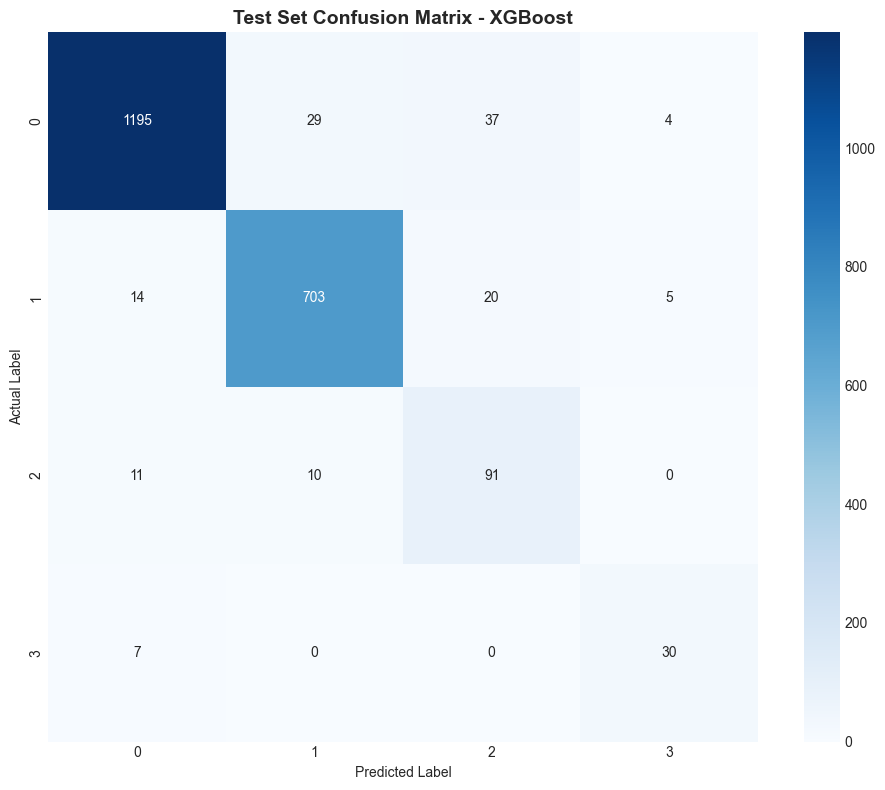

In [25]:
# Test set confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', square=True)
plt.title(f'Test Set Confusion Matrix - {best_model_name}', fontsize=14, weight='bold')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


---
## Phase 9: Model Deployment

Save the trained model and preprocessing objects for future use.


In [26]:
# Save best model
with open('data/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save scaler
with open('data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save label encoders
with open('data/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("✓ Model saved successfully!")
print("  Files created:")
print("  - data/best_model.pkl")
print("  - data/scaler.pkl")
print("  - data/label_encoders.pkl")


✓ Model saved successfully!
  Files created:
  - data/best_model.pkl
  - data/scaler.pkl
  - data/label_encoders.pkl


In [27]:
# Example: Making predictions on new data
print("\n" + "=" * 60)
print("EXAMPLE: Making Predictions on New Data")
print("=" * 60)

# Load saved model
with open('data/best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('data/scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Make prediction on first test sample
sample = X_test.iloc[0:1]
sample_scaled = loaded_scaler.transform(sample)
prediction = loaded_model.predict(sample_scaled)

print(f"\nSample features:")
for col, val in sample.iloc[0].items():
    print(f"  {col}: {val:.4f}")
print(f"\nPredicted class: {prediction[0]}")
print(f"Actual class: {y_test.iloc[0]}")
print(f"Match: {'✓ Correct!' if prediction[0] == y_test.iloc[0] else '✗ Incorrect'}")



EXAMPLE: Making Predictions on New Data



Sample features:
  MEAN_MOTION: 12.9696
  ECCENTRICITY: 0.0027
  INCLINATION: 90.2730
  RA_OF_ASC_NODE: 325.7206
  ARG_OF_PERICENTER: 182.0403
  MEAN_ANOMALY: 178.0613
  BSTAR: 0.0018
  MEAN_MOTION_DOT: 0.0000
  SEMIMAJOR_AXIS: 7652.1440
  PERIOD: 111.0280
  APOAPSIS: 1294.4950
  PERIAPSIS: 1253.5240
  REV_AT_EPOCH: 36475.0000
  COUNTRY_CODE: 95.0000
  CLASSIFICATION_TYPE: 0.0000

Predicted class: 0
Actual class: 0
Match: ✓ Correct!


---
## Summary

### What We Accomplished:

1. ✅ **Data Loading** - Loaded cleaned dataset from EDA notebook
2. ✅ **Feature Engineering** - Created orbit and altitude categories
3. ✅ **Data Preprocessing** - Encoding, splitting, scaling
4. ✅ **Class Imbalance Analysis** - Detected and handled with class weights
5. ✅ **Model Building** - Trained multiple algorithms:
   - Logistic Regression
   - Random Forest
   - XGBoost (optional)
6. ✅ **Cross-Validation** - 5-fold CV for robust estimates
7. ✅ **Advanced Evaluation**:
   - Confusion matrices
   - Learning curves
   - Feature importance
8. ✅ **Test Set Evaluation** - Final performance on unseen data
9. ✅ **Model Deployment** - Saved model and preprocessing objects

### Final Results:

**Best Model**: {best_model_name}
- **Validation Accuracy**: {results.loc[best_model_idx, 'Accuracy']:.4f}
- **Test Accuracy**: {accuracy_score(y_test, y_test_pred):.4f}
- **Test F1-Score**: {f1_score(y_test, y_test_pred, average='weighted'):.4f}

### Key Insights:
- Class imbalance handled with balanced class weights
- Cross-validation showed consistent performance
- Learning curves indicate {('good generalization' if final_gap < 0.1 else 'some overfitting')}
- Model ready for deployment

### Next Steps:
- Hyperparameter tuning with GridSearchCV
- Try ensemble methods (voting/stacking)
- Deploy model to production environment
- Monitor model performance over time
